# Analyzing KSU Flight Data

This will go through using the IPython Notebook as well as creating some markdown (or markup) to describe what each section is attempting to accomplish

## Getting Setup

<p>To get started there are several packages that we need to import in order to make full use of the notebook.  The lines preceded with % are commands for the notebook and are literally called <a href="https://ipython.org/ipython-doc/dev/interactive/magics.html">'Built-in magic commands</a>.  More specifically, the '%matplotlib inline' and '%pylab inline' commands will direct the notebook to generate an image and load it into the notebook inline.

* **pandas**: Library for dealing with data sets including time series.
* **numpy**: Provides interfaces to general array representation and mathematical operations.
* **matplotlib**: Provides numerous graphical plotting features.

In [2]:
%matplotlib inline
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib
matplotlib.style.use('ggplot')

figsize(15, 5)

data_dir = '/home/dingbat/data/aviation/ksu/N102KS'

Populating the interactive namespace from numpy and matplotlib


## Reading in the Data

Next the data file must be loaded.  In this case pandas provides the read_csv command that provides numerous functional arguments to massage the data into a usable form.

* **parse_dates**: Provided a python dictionary, pandas will create a column per item in the dictionary.  The column will be Timestamp type and named after the key.  The value of the dictionary item is the name of the column to parse.  If a list is provided the columns will be concatenated in the order they are provided and the result parsed.
* **header**: The zero-based row to use for the header.  These are the names that will be used to access the data later.  A list can be provided if the header is composed from multiple rows.
* **skipinitialspace**: Some formats, such as the KSU data, are both delimited and fixed width.  Therefore, when reading in the data, the leading spaces must be cleaned to get to the actual data.
* **index_col**: The pandas package will create an index on the data.  This serves many purposes including the general printout of a requested column.  It also serves as a the factor for combining data.

In [3]:
name_ts = 'timestamp'
df = pd.read_csv(
    #'/home/dingbat/data/aviation/KSU/flights/N102KS Data Log thru 10-28-2013/log_120511_083026_1G3.csv',
    os.path.join(data_dir, 'log_120615_165246_1G3.csv'),
    parse_dates={name_ts: ['Lcl Date', 'Lcl Time', 'UTCOfst']},
    header=2,
    skipinitialspace=True,
    index_col=name_ts,
)

In [4]:
len(df)  # Total number of rows in the data.

1337

In [5]:
df[:5]  # Display the first 5 rows.

,AtvWpt,Latitude,Longitude,AltB,BaroA,AltMSL,OAT,IAS,GndSpd,VSpd,...,PitchM,RollC,PichC,VSpdG,GPSfix,HAL,VAL,HPLwas,HPLfd,VPLwas
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-06-15 20:52:33,NaN,NaN,NaN,1090.8,30.15,NaN,34.5,0,NaN,12.35,...,NaN,NaN,NaN,NaN,NoSoln,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:33,NaN,NaN,NaN,1090.8,30.15,NaN,34.5,0,NaN,12.35,...,NaN,NaN,NaN,NaN,NoSoln,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:35,NaN,41.156838,-81.417236,1090.8,30.15,1156.3,34.5,0,0,13.94,...,NaN,NaN,NaN,0.7,3D,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:36,NaN,41.156838,-81.417236,1090.8,30.15,1156.9,34.5,0,0,-1.03,...,NaN,NaN,NaN,-0.9,3D,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:37,NaN,41.156838,-81.417236,1090.8,30.15,1157.5,34.2,0,0,-7.54,...,NaN,NaN,NaN,-0.5,3D,3704,NaN,NaN,NaN,NaN


A list of the columns in the data

In [6]:
df.columns

Index(['AtvWpt', 'Latitude', 'Longitude', 'AltB', 'BaroA', 'AltMSL', 'OAT', 'IAS', 'GndSpd', 'VSpd', 'Pitch', 'Roll', 'LatAc', 'NormAc', 'HDG', 'TRK', 'volt1', 'volt2', 'amp1', 'amp2', 'FQtyL', 'FQtyR', 'E1 FFlow', 'E1 OilT', 'E1 OilP', 'E1 RPM', 'E1 CHT1', 'E1 CHT2', 'E1 CHT3', 'E1 CHT4', 'E1 EGT1', 'E1 EGT2', 'E1 EGT3', 'E1 EGT4', 'AltGPS', 'TAS', 'HSIS', 'CRS', 'NAV1', 'NAV2', 'COM1', 'COM2', 'HCDI', 'VCDI', 'WndSpd', 'WndDr', 'WptDst', 'WptBrg', 'MagVar', 'AfcsOn', 'RollM', 'PitchM', 'RollC', 'PichC', 'VSpdG', 'GPSfix', 'HAL', 'VAL', 'HPLwas', 'HPLfd', 'VPLwas'], dtype='object')

The parameters 'AtvWpt', 'HSIS', and 'GPSfix' are all read in as objects.  When attempting to write out the H5 data there is a performance warning.  Most examples read in strings as objects so I'm not sure this is wrong.  However, when there is a blank string (resulting from cutting out the initial space), it is interpreted as NaN, which isn't really what we want to a string.

In [7]:
df.loc[:,['AtvWpt', 'HSIS', 'GPSfix']].dtypes

AtvWpt    float64
HSIS       object
GPSfix     object
dtype: object

The data is also indexed by the time.  This is useful for merging parameters and performing other operations where the index defines how the data relates.  In this data set we have the timezone offset so all times can be correlated to UTC.

In [8]:
df.index

<class 'pandas.tseries.index.DatetimeIndex'>
[2012-06-15 20:52:33, ..., 2012-06-15 21:15:46]
Length: 1337, Freq: None, Timezone: None

## Adjusting the data to align to GPS time

When the aircraft starts up it starts recording data.  This is useful since there are many subsystems that are producing good data immediately.  However, as a time series data set there is no overarching timestamp until the GPS is locked.  Therefore we want to scan the data and then synchronize backward in time.  Below we can see that when the data has a GPS fix, it is recorded in the data.

In [9]:
df['GPSfix'][:5]

timestamp
2012-06-15 20:52:33    NoSoln
2012-06-15 20:52:33    NoSoln
2012-06-15 20:52:35        3D
2012-06-15 20:52:36        3D
2012-06-15 20:52:37        3D
Name: GPSfix, dtype: object

In [10]:
df['GPSfix'].index[0], df['GPSfix'].index[1], df['GPSfix'].index[2]

(Timestamp('2012-06-15 20:52:33'),
 Timestamp('2012-06-15 20:52:33'),
 Timestamp('2012-06-15 20:52:35'))

In [11]:
ts = df[df['GPSfix'] == '3D'].index.tolist()[0]
ts

Timestamp('2012-06-15 20:52:35')

In [12]:
num = int(np.where(df['GPSfix'] == '3D')[0][0])
num

2

In [13]:
index = df.index
names = index.names
index = [(ts - pd.DateOffset(seconds=num-i)) for i in range(num)] + df.index.tolist()[num:]
df.index = pd.tseries.index.DatetimeIndex(index)
df[:5]

,AtvWpt,Latitude,Longitude,AltB,BaroA,AltMSL,OAT,IAS,GndSpd,VSpd,...,PitchM,RollC,PichC,VSpdG,GPSfix,HAL,VAL,HPLwas,HPLfd,VPLwas
2012-06-15 20:52:33,NaN,NaN,NaN,1090.8,30.15,NaN,34.5,0,NaN,12.35,...,NaN,NaN,NaN,NaN,NoSoln,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:34,NaN,NaN,NaN,1090.8,30.15,NaN,34.5,0,NaN,12.35,...,NaN,NaN,NaN,NaN,NoSoln,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:35,NaN,41.156838,-81.417236,1090.8,30.15,1156.3,34.5,0,0,13.94,...,NaN,NaN,NaN,0.7,3D,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:36,NaN,41.156838,-81.417236,1090.8,30.15,1156.9,34.5,0,0,-1.03,...,NaN,NaN,NaN,-0.9,3D,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:37,NaN,41.156838,-81.417236,1090.8,30.15,1157.5,34.2,0,0,-7.54,...,NaN,NaN,NaN,-0.5,3D,3704,NaN,NaN,NaN,NaN


In [14]:
df['GPSfix'].index[0], df['GPSfix'].index[1], df['GPSfix'].index[2]

(Timestamp('2012-06-15 20:52:33'),
 Timestamp('2012-06-15 20:52:34'),
 Timestamp('2012-06-15 20:52:35'))

## Calculating Properties

There are several properties that a flight can access through its interface including:
1. *start time*
1. *end time*
1. *duration*
1. *sync_time* (Time when GPS lock is first acquired)
1. *object_id* (e.g. A Tail number of an aircraft)
1. *type_model*
1. *position* - A merged table for longitude, latitude, and altitude over time

In [15]:
df.index[0]

Timestamp('2012-06-15 20:52:33')

In [16]:
df.index[-1]

Timestamp('2012-06-15 21:15:46')

In [17]:
df.index[-1] - df.index[0]

Timedelta('0 days 00:23:13')

In [18]:
df.index[num]

Timestamp('2012-06-15 20:52:35')

## Slicing the Data by Parameter

In [19]:
s = df['Latitude']
s.name

'Latitude'

In [20]:
len(s)

1337

In [21]:
l = [p for p in s.iteritems()]
l[:10]

[(Timestamp('2012-06-15 20:52:33'), nan),
 (Timestamp('2012-06-15 20:52:34'), nan),
 (Timestamp('2012-06-15 20:52:35'), 41.156837500000002),
 (Timestamp('2012-06-15 20:52:36'), 41.156837500000002),
 (Timestamp('2012-06-15 20:52:37'), 41.156837500000002),
 (Timestamp('2012-06-15 20:52:38'), 41.156833599999999),
 (Timestamp('2012-06-15 20:52:39'), 41.156833599999999),
 (Timestamp('2012-06-15 20:52:40'), 41.156833599999999),
 (Timestamp('2012-06-15 20:52:41'), 41.156833599999999),
 (Timestamp('2012-06-15 20:52:42'), 41.156833599999999)]

In [22]:
l[0]

(Timestamp('2012-06-15 20:52:33'), nan)

## Plotting Data

In [23]:
print(plt.style.available)

['grayscale', 'bmh', 'fivethirtyeight', 'dark_background', 'ggplot']


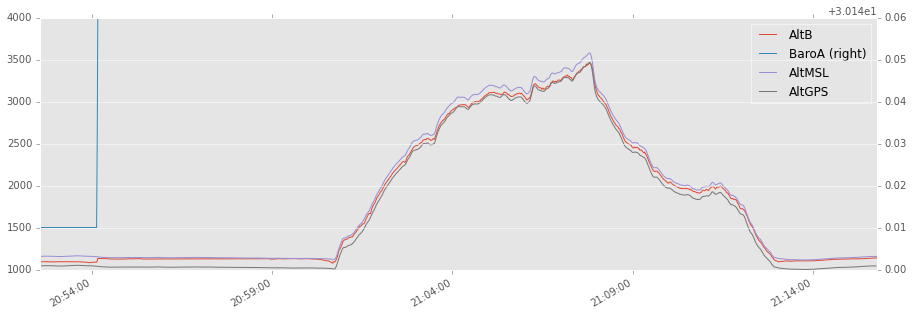

In [25]:
plt.figure()
plt_df = df[['AltB', 'BaroA', 'AltMSL', 'AltGPS']]
plt_df.plot(secondary_y=['BaroA'])

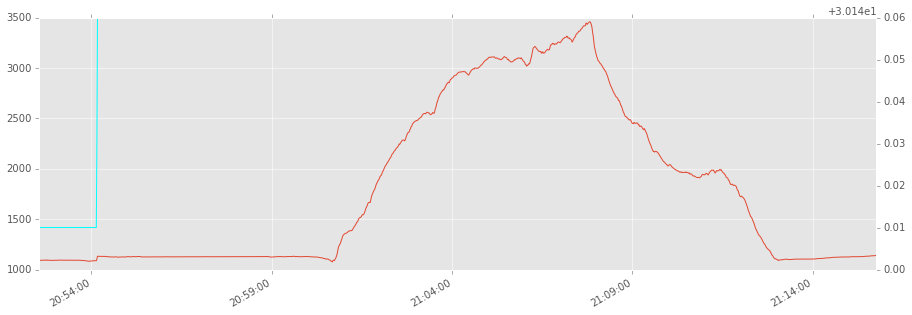

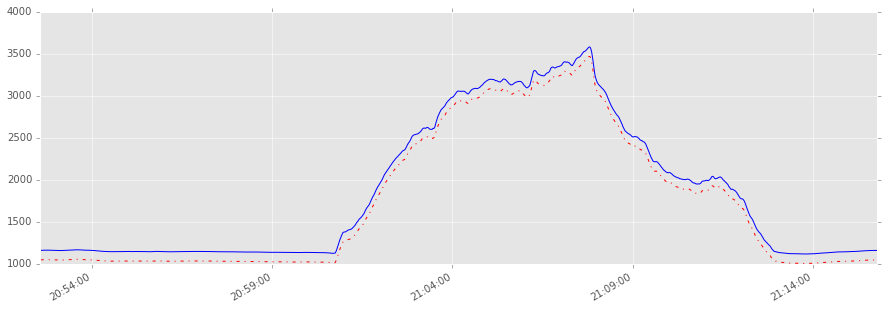

In [37]:
plt.figure()
df['AltB'].plot()
df['BaroA'].plot(secondary_y=True, style='cyan')
df['AltMSL'].plot(style='b')
df['AltGPS'].plot(style='r-.')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4702020cf8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f4701c6a6a0>], dtype=object)

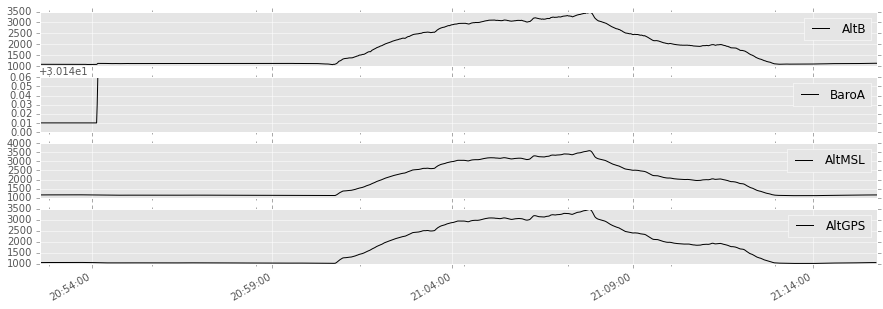

In [31]:
df[['AltB', 'BaroA', 'AltMSL', 'AltGPS']].plot(subplots=True)

In [28]:
evt_data = df[['AltMSL', 'VSpd', 'GndSpd']]
evt_data[:5]

,AltMSL,VSpd,GndSpd
2012-06-15 20:52:33,NaN,12.35,NaN
2012-06-15 20:52:34,NaN,12.35,NaN
2012-06-15 20:52:35,1156.3,13.94,0
2012-06-15 20:52:36,1156.9,-1.03,0
2012-06-15 20:52:37,1157.5,-7.54,0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4701aa31d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f47019f7710>], dtype=object)

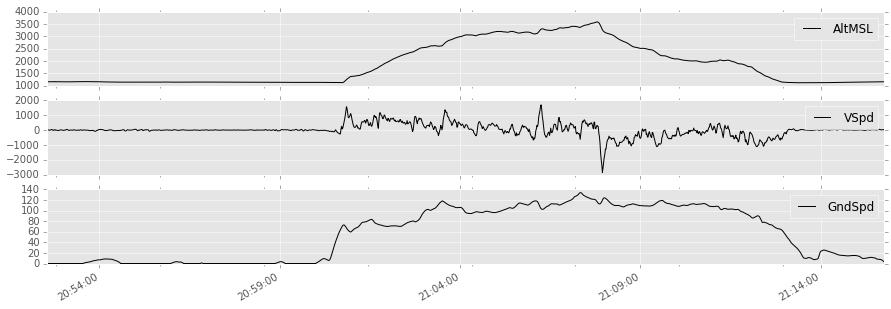

In [35]:
evt_data.plot(subplots=True)

In [30]:
from pandas.io.pytables import HDFStore
store = HDFStore(os.path.join(data_dir, '../', 'log_120511_083026_1G3.h5'))
store['FlightData'] = df
print(store)
store.close()

<class 'pandas.io.pytables.HDFStore'>
File path: /home/dingbat/data/aviation/ksu/N102KS/../log_120511_083026_1G3.h5
/FlightData            frame        (shape->[1337,61])


/usr/lib64/python3.4/site-packages/pandas/io/pytables.py:2558: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['HSIS', 'GPSfix']]

  warnings.warn(ws, PerformanceWarning)


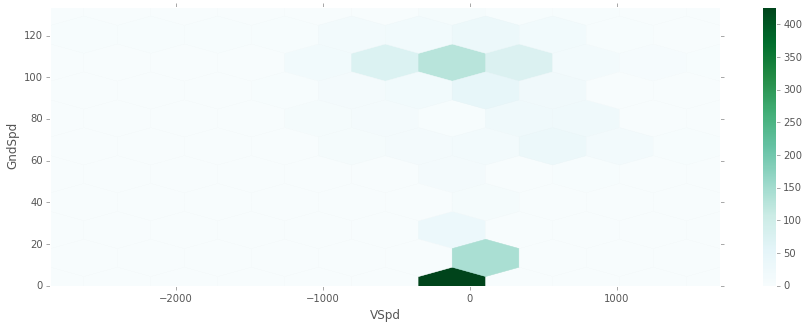

In [31]:
evt_data.plot(kind='hexbin', x='VSpd', y='GndSpd', gridsize=10)

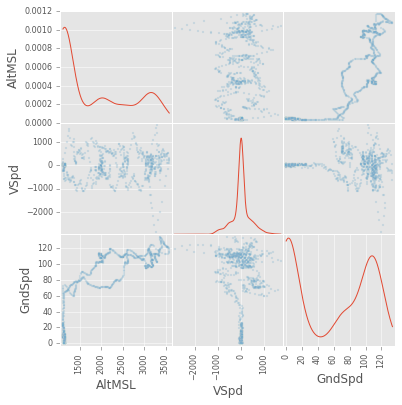

In [44]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(evt_data, alpha=0.2, figsize=(6, 6), diagonal='kde')[0][0]

In [33]:
start_time = df.index[10].to_datetime()
duration = datetime.timedelta(seconds=5)
start_time, duration, start_time+duration

(datetime.datetime(2012, 6, 15, 20, 52, 43),
 datetime.timedelta(0, 5),
 datetime.datetime(2012, 6, 15, 20, 52, 48))

In [34]:
#q = df[['Longitude','Latitude','AltGPS']].dropna()
q = df.loc[start_time:start_time+duration,]
q

,AtvWpt,Latitude,Longitude,AltB,BaroA,AltMSL,OAT,IAS,GndSpd,VSpd,...,PitchM,RollC,PichC,VSpdG,GPSfix,HAL,VAL,HPLwas,HPLfd,VPLwas
2012-06-15 20:52:43,NaN,41.156834,-81.417236,1091.8,30.15,1158.7,34.0,0,0,-12.13,...,NaN,NaN,NaN,-1.0,3D,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:44,NaN,41.156834,-81.417236,1092.8,30.15,1158.9,34.0,0,0,-5.36,...,NaN,NaN,NaN,0.1,3D,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:46,NaN,41.156834,-81.417236,1093.8,30.15,1159.0,33.8,0,0,28.19,...,NaN,NaN,NaN,-3.2,3D,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:46,NaN,41.156834,-81.417236,1092.8,30.15,1158.8,33.8,0,0,14.79,...,NaN,NaN,NaN,-3.2,3D,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:47,NaN,41.156834,-81.417236,1092.8,30.15,1158.8,33.8,0,0,-3.47,...,NaN,NaN,NaN,-1.3,3D,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:48,NaN,41.156834,-81.417236,1092.8,30.15,1158.6,33.8,0,0,-1.71,...,NaN,NaN,NaN,0.4,3D,3704,NaN,NaN,NaN,NaN


In [35]:
import dateutil
dateutil.parser.parse('2015-03-06')

datetime.datetime(2015, 3, 6, 0, 0)

In [36]:
q = df.loc[None:None,]
q

,AtvWpt,Latitude,Longitude,AltB,BaroA,AltMSL,OAT,IAS,GndSpd,VSpd,...,PitchM,RollC,PichC,VSpdG,GPSfix,HAL,VAL,HPLwas,HPLfd,VPLwas
2012-06-15 20:52:33,NaN,NaN,NaN,1090.8,30.15,NaN,34.5,0,NaN,12.35,...,NaN,NaN,NaN,NaN,NoSoln,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:34,NaN,NaN,NaN,1090.8,30.15,NaN,34.5,0,NaN,12.35,...,NaN,NaN,NaN,NaN,NoSoln,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:35,NaN,41.156838,-81.417236,1090.8,30.15,1156.3,34.5,0,0.00,13.94,...,NaN,NaN,NaN,0.7,3D,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:36,NaN,41.156838,-81.417236,1090.8,30.15,1156.9,34.5,0,0.00,-1.03,...,NaN,NaN,NaN,-0.9,3D,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:37,NaN,41.156838,-81.417236,1090.8,30.15,1157.5,34.2,0,0.00,-7.54,...,NaN,NaN,NaN,-0.5,3D,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:38,NaN,41.156834,-81.417236,1090.8,30.15,1158.0,34.2,0,0.00,-0.03,...,NaN,NaN,NaN,2.0,3D,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:39,NaN,41.156834,-81.417236,1091.8,30.15,1158.3,34.2,0,0.00,6.42,...,NaN,NaN,NaN,-1.2,3D,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:40,NaN,41.156834,-81.417236,1092.8,30.15,1158.5,34.2,0,0.00,36.54,...,NaN,NaN,NaN,-0.7,3D,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:41,NaN,41.156834,-81.417236,1093.8,30.15,1158.6,34.0,0,0.00,42.80,...,NaN,NaN,NaN,-1.4,3D,3704,NaN,NaN,NaN,NaN
2012-06-15 20:52:42,NaN,41.156834,-81.417236,1091.8,30.15,1158.7,34.0,0,0.00,-1.44,...,NaN,NaN,NaN,0.2,3D,3704,NaN,NaN,NaN,NaN


## Calculating Events

In [37]:
resampled = evt_data.resample(rule='100L')
resampled[:11]

,AltMSL,VSpd,GndSpd
2012-06-15 20:52:33,NaN,12.35,NaN
2012-06-15 20:52:33.100000,NaN,NaN,NaN
2012-06-15 20:52:33.200000,NaN,NaN,NaN
2012-06-15 20:52:33.300000,NaN,NaN,NaN
2012-06-15 20:52:33.400000,NaN,NaN,NaN
2012-06-15 20:52:33.500000,NaN,NaN,NaN
2012-06-15 20:52:33.600000,NaN,NaN,NaN
2012-06-15 20:52:33.700000,NaN,NaN,NaN
2012-06-15 20:52:33.800000,NaN,NaN,NaN
2012-06-15 20:52:33.900000,NaN,NaN,NaN


In [38]:
resampled = resampled.interpolate(method='linear')
resampled[10:20]

,AltMSL,VSpd,GndSpd
2012-06-15 20:52:34,NaN,12.350,NaN
2012-06-15 20:52:34.100000,NaN,12.509,NaN
2012-06-15 20:52:34.200000,NaN,12.668,NaN
2012-06-15 20:52:34.300000,NaN,12.827,NaN
2012-06-15 20:52:34.400000,NaN,12.986,NaN
2012-06-15 20:52:34.500000,NaN,13.145,NaN
2012-06-15 20:52:34.600000,NaN,13.304,NaN
2012-06-15 20:52:34.700000,NaN,13.463,NaN
2012-06-15 20:52:34.800000,NaN,13.622,NaN
2012-06-15 20:52:34.900000,NaN,13.781,NaN


In [39]:
test = evt_data[evt_data['AltMSL'] > 3000]
test = test[test.VSpd > 700]
test = test[test.GndSpd > 60]
test

,AltMSL,VSpd,GndSpd
2012-06-15 21:06:11,3175.3,889.67,112.53
2012-06-15 21:06:12,3205.1,1096.19,109.95
2012-06-15 21:06:13,3237.9,1314.08,107.26
2012-06-15 21:06:14,3267.0,1596.33,104.87
2012-06-15 21:06:15,3287.3,1703.71,103.38
2012-06-15 21:06:16,3294.4,1385.54,102.66
2012-06-15 21:06:17,3297.7,916.27,102.43
2012-06-15 21:06:44,3325.6,803.47,110.85
2012-06-15 21:06:45,3331.6,854.11,110.50


In [40]:
tspi = df[['Longitude', 'Latitude', 'AltMSL']]
tspi[:5]

,Longitude,Latitude,AltMSL
2012-06-15 20:52:33,NaN,NaN,NaN
2012-06-15 20:52:34,NaN,NaN,NaN
2012-06-15 20:52:35,-81.417236,41.156838,1156.3
2012-06-15 20:52:36,-81.417236,41.156838,1156.9
2012-06-15 20:52:37,-81.417236,41.156838,1157.5


In [41]:
res = evt_data.resample(rule='100L')
test = res['AltMSL']
test = test.dropna()
test

2012-06-15 20:52:35    1156.3
2012-06-15 20:52:36    1156.9
2012-06-15 20:52:37    1157.5
2012-06-15 20:52:38    1158.0
2012-06-15 20:52:39    1158.3
2012-06-15 20:52:40    1158.5
2012-06-15 20:52:41    1158.6
2012-06-15 20:52:42    1158.7
2012-06-15 20:52:43    1158.7
2012-06-15 20:52:44    1158.9
2012-06-15 20:52:46    1158.9
2012-06-15 20:52:47    1158.8
2012-06-15 20:52:48    1158.6
2012-06-15 20:52:49    1158.5
2012-06-15 20:52:50    1158.5
2012-06-15 20:52:51    1158.3
2012-06-15 20:52:52    1158.2
2012-06-15 20:52:53    1158.0
2012-06-15 20:52:54    1157.8
2012-06-15 20:52:55    1157.5
2012-06-15 20:52:56    1157.3
2012-06-15 20:52:57    1156.9
2012-06-15 20:52:58    1156.6
2012-06-15 20:52:59    1156.3
2012-06-15 20:53:00    1156.0
2012-06-15 20:53:01    1155.6
2012-06-15 20:53:02    1155.3
2012-06-15 20:53:03    1155.0
2012-06-15 20:53:04    1154.7
2012-06-15 20:53:05    1154.5
                        ...  
2012-06-15 21:15:17    1146.9
2012-06-15 21:15:18    1147.2
2012-06-15

In [42]:
lat = df['Latitude']
lon = df['Longitude']
alt = df['AltGPS']
hdg = df['HDG']
pch = df['Pitch']
rol = df['Roll']
%timeit -r1 pd.concat((lon, lat, alt, hdg, pch, rol))

1000 loops, best of 1: 1.59 ms per loop


In [43]:
%timeit -r df[['Latitude', 'Longitude', 'AltGPS', 'HDG', 'Pitch', 'Roll']]

ValueError: invalid literal for int() with base 10: "df[['Latitude',"

In [ ]:
import pickle
with open('/home/dingbat/Downloads/N102KS-2013-10-28T11-33-14+00-00.pkl', 'rb') as f:
    df2 = pickle.load(f)
df2

In [ ]:
arr = [1,2]
arr[-2]